In [59]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

In [61]:
# Load the dataset
df_skin = pd.read_csv('D:/Project Data/HAM10000_metadata.csv')
df_skin.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [63]:
# Define lesion types and IDs
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}


In [65]:
# Map lesion types and IDs
df_skin['lesion_type'] = df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

In [73]:
# Function to produce new augmented images
def produce_new_img(img2: np.ndarray) -> tuple:
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)  # Vertical flip
    imge = cv2.flip(img2, 1)  # Horizontal flip
    return imga, imgb, imgc, imgd, imge

# Define a custom generator to handle class imbalance
class WeightedImageGenerator(Sequence):
    def __init__(self, file_list, df_skin, batch_size, lesion_ID_dict, augment=True):
        self.file_list = file_list
        self.df_skin = df_skin
        self.batch_size = batch_size
        self.lesion_ID_dict = lesion_ID_dict
        self.augment = augment

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        batch_files = self.file_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        x_batch = []
        y_batch = []
        
        for fname in batch_files:
            # Load image
            fname_ID = fname.replace('.jpg', '')
            file_to_read = os.path.join("D:/Project Data/Part1", fname)
            img = imread(file_to_read)
            img_resized = resize(img, (100, 100))
            
            # Append image and label
            x_batch.append(img_resized)
            lesion_ID = self.df_skin[self.df_skin['image_id'] == fname_ID]['lesion_ID'].values[0]
            y_batch.append(lesion_ID)
            
            # Data augmentation for minority classes
            if self.augment and lesion_ID != 0:
                augmented_imgs = produce_new_img(img_resized)
                for aug_img in augmented_imgs:
                    x_batch.append(aug_img)
                    y_batch.append(lesion_ID)
        
        # Convert to numpy arrays
        x_batch = np.array(x_batch)
        y_batch = to_categorical(y_batch, num_classes=7)
        
        print(f"Returning batch {idx} of size {x_batch.shape}")  # Debugging line
        return x_batch, y_batch


In [77]:
# Prepare file list and split into training and test sets
file_list = os.listdir("D:/Project Data/Part1")
train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=50, stratify=df_skin['lesion_ID'])



In [79]:
# Build the model
model = Sequential()
model.add(Conv2D(16, (11, 11), strides=(4, 4), activation='relu', input_shape=(100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(64, (1, 1), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(128, (1, 1), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
# Compile the model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping_monitor = EarlyStopping(patience=100, monitor='val_accuracy')
model_checkpoint_callback = ModelCheckpoint(filepath='model.keras', save_weights_only=False, monitor='val_accuracy', mode='auto', save_best_only=True, verbose=1)

# Train the model using the generator
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(test_files) // batch_size

In [83]:
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=test_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping_monitor, model_checkpoint_callback]
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.2494 - loss: 2.7001
Epoch 1: val_accuracy improved from -inf to 0.10887, saving model to model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 205s 791ms/step - accuracy: 0.2495 - loss: 2.6979 - val_accuracy: 0.1089 - val_loss: 2.1003
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100


D:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
D:\Anaconda\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
D:\Anaconda\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.3576 - loss: 1.6872
Epoch 3: val_accuracy improved from 0.10887 to 0.18448, saving model to model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 108s 433ms/step - accuracy: 0.3576 - loss: 1.6871 - val_accuracy: 0.1845 - val_loss: 1.8236
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.3812 - loss: 1.5986
Epoch 5: val_accuracy improved from 0.18448 to 0.60736, saving model to model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 429ms/step - accuracy: 0.3812 - loss: 1.5984 - val_accuracy: 0.6074 - val_loss: 1.0261
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 69us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4306 - loss: 1.4720
Epoch 7: val_accuracy improved from 0.60736 to 0.64012, saving model to model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 429ms/step - accuracy: 0.

In [85]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

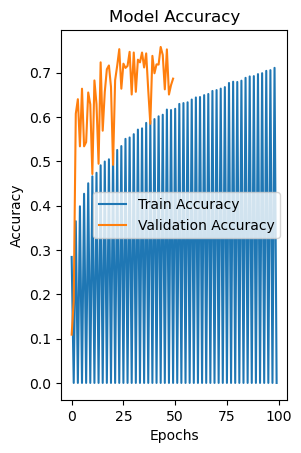

In [87]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

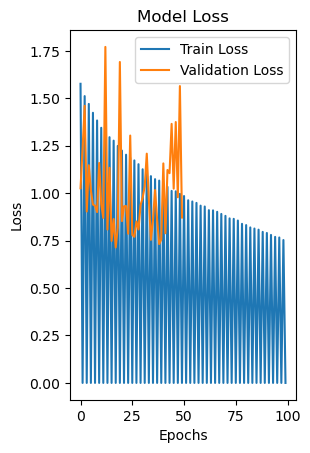

In [32]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

In [89]:
plt.tight_layout()
plt.show()

print("Training complete!")

<Figure size 640x480 with 0 Axes>

Training complete!


In [91]:
# Evaluate the model
scores = model.evaluate(test_gen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.6765 - loss: 0.8831
Accuracy: 68.65%


In [55]:
x_batch, y_batch = test_gen.__getitem__(0)  # Retrieve batch 0 (or any other index)

print(x_batch.shape)
print(y_batch.shape)

(32, 100, 100, 3)
(32, 7)


In [103]:
# Loop through the test generator manually with diagnostic outputs
for i in range(test_steps):
    try:
        # Retrieve a batch from the generator
        x_batch, y_batch = test_gen[i]
        
        # Check if batch is empty or improperly generated
        if x_batch.shape[0] == 0:
            print(f"Batch {i} is empty, skipping.")
            continue
        
        # Make predictions on the current batch
        y_pred_prob_batch = model.predict(x_batch, verbose=0)
        y_pred_prob.append(y_pred_prob_batch)
        
        # Gather true labels for the batch
        y_test_batch = np.argmax(y_batch, axis=1)
        y_test2.extend(y_test_batch)

        print(f"Processed batch {i+1}/{test_steps}")
        
    except Exception as e:
        print(f"Error during batch {i+1} prediction: {e}")
        break

Returning batch 0 of size (32, 100, 100, 3)
Processed batch 1/62
Returning batch 1 of size (32, 100, 100, 3)
Processed batch 2/62
Returning batch 2 of size (32, 100, 100, 3)
Processed batch 3/62
Returning batch 3 of size (32, 100, 100, 3)
Processed batch 4/62
Returning batch 4 of size (32, 100, 100, 3)
Processed batch 5/62
Returning batch 5 of size (32, 100, 100, 3)
Processed batch 6/62
Returning batch 6 of size (32, 100, 100, 3)
Processed batch 7/62
Returning batch 7 of size (32, 100, 100, 3)
Processed batch 8/62
Returning batch 8 of size (32, 100, 100, 3)
Processed batch 9/62
Returning batch 9 of size (32, 100, 100, 3)
Processed batch 10/62
Returning batch 10 of size (32, 100, 100, 3)
Processed batch 11/62
Returning batch 11 of size (32, 100, 100, 3)
Processed batch 12/62
Returning batch 12 of size (32, 100, 100, 3)
Processed batch 13/62
Returning batch 13 of size (32, 100, 100, 3)
Processed batch 14/62
Returning batch 14 of size (32, 100, 100, 3)
Processed batch 15/62
Returning batc

In [105]:
# Convert list of arrays to a single array
y_pred_prob = np.concatenate(y_pred_prob, axis=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure true labels are a single array
y_test2 = np.array(y_test2)

In [107]:
# Calculate metrics if predictions were successful
if len(y_test2) > 0:
    accuracy = accuracy_score(y_test2, y_pred)
    report = classification_report(y_test2, y_pred, target_names=list(lesion_type_dict.values()), output_dict=True)

In [111]:

    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    
    # Print final results
    print('Final Results:')
    print('-----------------')
    print(f'Overall Accuracy: {round(accuracy * 100, 2)}%')
    print(f'Precision: {round(precision, 3)}')
    print(f'Recall: {round(recall, 3)}')
    print(f'F1 Score: {round(f1_score, 3)}')


Final Results:
-----------------
Overall Accuracy: 68.65%
Precision: 0.779
Recall: 0.686
F1 Score: 0.712


In [139]:

    
    # Print the full classification report for detailed per-class metrics
    print("\nClassification Report:\n", report)
 


Classification Report:
 {'Melanocytic nevi': {'precision': 0.9412878787878788, 'recall': 0.7395833333333334, 'f1-score': 0.8283333333333334, 'support': 1344.0}, 'Melanoma': {'precision': 0.3231597845601436, 'recall': 0.7894736842105263, 'f1-score': 0.4585987261146497, 'support': 228.0}, 'Benign keratosis-like lesions': {'precision': 0.4807692307692308, 'recall': 0.47619047619047616, 'f1-score': 0.4784688995215311, 'support': 210.0}, 'Basal cell carcinoma': {'precision': 0.6136363636363636, 'recall': 0.5094339622641509, 'f1-score': 0.5567010309278351, 'support': 106.0}, 'Actinic keratoses': {'precision': 0.4583333333333333, 'recall': 0.38596491228070173, 'f1-score': 0.41904761904761906, 'support': 57.0}, 'Vascular lesions': {'precision': 0.4782608695652174, 'recall': 0.6111111111111112, 'f1-score': 0.5365853658536586, 'support': 18.0}, 'Dermatofibroma': {'precision': 0.25, 'recall': 0.047619047619047616, 'f1-score': 0.08, 'support': 21.0}, 'accuracy': 0.686491935483871, 'macro avg': {'